In [3]:
COLAB = True

In [4]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import spacy
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from collections import Counter
from google.colab import drive
import os

In [5]:
RANDOM_STATE = 30255
BATCH_SIZE = 32
MAX_LENGTH = 512
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

In [6]:
if COLAB:
  drive.mount('/content/gdrive')
  PATH = "gdrive/Shareddrives/Adv ML Project/Data/"
  df = pd.read_csv(os.path.join(PATH + "preprocessed_data.csv"))

else:
  df = pd.read_csv('../data/preprocessed_data.csv')
  df = df.sample(n=100, random_state=RANDOM_STATE).reset_index()


le = preprocessing.LabelEncoder()
le.fit(df['CLASS'])
df['LABEL'] = le.transform(df['CLASS'])

df.head()

Mounted at /content/gdrive


,DESCRIPTION,SUBJECT,MAIN_SUBJECT,CLASS,BERT_TOKENIZED,SPACY_PREPROCESSED,LABEL
0,The United States Department of Energy Vehicle...,"['33 Advanced Propulsion Systems', '36 Materia...",33 Advanced Propulsion Systems,"Energy Storage, Conversion, and Utilization","{'input_ids': tensor([[ 101, 1996, 2142, 2...",united states department energy vehicle techno...,0
1,Solar reflective “cool pavements” have been pr...,"['32 Energy Conservation, Consumption, And Uti...","32 Energy Conservation, Consumption, And Utili...","Energy Storage, Conversion, and Utilization","{'input_ids': tensor([[ 101, 5943, 21346, 1...",solar reflective cool pavement propose potenti...,0
2,Inconel 718 alloy is used extensively in aerog...,"['36 Materials Science', '33 Advanced Propulsi...",33 Advanced Propulsion Systems,"Energy Storage, Conversion, and Utilization","{'input_ids': tensor([[ 101, 4297, 5643, 2...",inconel alloy extensively aerogas turbine allo...,0
3,The Production Tax Credit (PTC) and the Invest...,"['29 Energy Planning, Policy, And Economy', 'P...","29 Energy Planning, Policy, And Economy","Energy Storage, Conversion, and Utilization","{'input_ids': tensor([[ 101, 1996, 2537, 4...",production tax credit ptc investment tax credi...,0
4,The production tax credit (PTC) promotes wind ...,"['29 Energy Planning, Policy, And Economy', '1...","29 Energy Planning, Policy, And Economy","Energy Storage, Conversion, and Utilization","{'input_ids': tensor([[ 101, 1996, 2537, 4...",production tax credit ptc promote wind energy ...,0


In [7]:
tmp_dict = df[['CLASS', 'LABEL']].drop_duplicates().set_index('LABEL').to_dict('index')
CATEGORY_DICT = {label: sub_dict['CLASS'] for label, sub_dict in tmp_dict.items()}

In [39]:
tok = spacy.load('en_core_web_sm')

In [40]:
def tokenize (text):
    return [token.text for token in tok.tokenizer(text)]

In [41]:
#count number of occurences of each word
counts = Counter()
for index, row in df.iterrows():
    counts.update(tokenize(row['SPACY_PREPROCESSED']))

In [42]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 30719
num_words after: 17571


In [43]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [44]:
# encode from scratch
def encode_sentence(text, vocab2index, N=MAX_LENGTH):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [45]:
df['encoded'] = df['SPACY_PREPROCESSED'].apply(lambda x: np.array(encode_sentence(x,vocab2index ), dtype=object))
df.head()

,DESCRIPTION,SUBJECT,MAIN_SUBJECT,CLASS,BERT_TOKENIZED,SPACY_PREPROCESSED,LABEL,encoded
0,The United States Department of Energy Vehicle...,"['33 Advanced Propulsion Systems', '36 Materia...",33 Advanced Propulsion Systems,"Energy Storage, Conversion, and Utilization","{'input_ids': tensor([[ 101, 1996, 2142, 2...",united states department energy vehicle techno...,0,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ..."
1,Solar reflective “cool pavements” have been pr...,"['32 Energy Conservation, Consumption, And Uti...","32 Energy Conservation, Consumption, And Utili...","Energy Storage, Conversion, and Utilization","{'input_ids': tensor([[ 101, 5943, 21346, 1...",solar reflective cool pavement propose potenti...,0,"[[87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, ..."
2,Inconel 718 alloy is used extensively in aerog...,"['36 Materials Science', '33 Advanced Propulsi...",33 Advanced Propulsion Systems,"Energy Storage, Conversion, and Utilization","{'input_ids': tensor([[ 101, 4297, 5643, 2...",inconel alloy extensively aerogas turbine allo...,0,"[[179, 180, 181, 1, 182, 180, 183, 184, 185, 1..."
3,The Production Tax Credit (PTC) and the Invest...,"['29 Energy Planning, Policy, And Economy', 'P...","29 Energy Planning, Policy, And Economy","Energy Storage, Conversion, and Utilization","{'input_ids': tensor([[ 101, 1996, 2537, 4...",production tax credit ptc investment tax credi...,0,"[[56, 248, 249, 250, 251, 248, 249, 252, 253, ..."
4,The production tax credit (PTC) promotes wind ...,"['29 Energy Planning, Policy, And Economy', '1...","29 Energy Planning, Policy, And Economy","Energy Storage, Conversion, and Utilization","{'input_ids': tensor([[ 101, 1996, 2537, 4...",production tax credit ptc promote wind energy ...,0,"[[56, 248, 249, 250, 267, 256, 5, 268, 101, 26..."


In [46]:
Counter(df['CLASS'])

Counter({'Energy Storage, Conversion, and Utilization': 1223,
         'Environmental Sciences': 1223,
         'Fission and Nuclear Technologies': 1223,
         'Fossil Fuels': 1223,
         'Renewable Energy Sources': 1223})

In [47]:
X = list(df['encoded'])
y = list(df['LABEL'])
texts = list(df['DESCRIPTION'])  

X_train, X_valid, y_train, y_valid, texts_train, texts_valid = train_test_split(
    X, 
    y, 
    texts, 
    train_size=0.7, 
    test_size=0.15, 
    random_state=RANDOM_STATE, 
    shuffle=True)

In [48]:
class ResearchDataSet(Dataset):
    def __init__(self, X, Y, text_data):
        self.X = X
        self.y = Y
        self.text_data = text_data
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return (torch.from_numpy(self.X[idx][0].astype(np.int32)), 
                self.y[idx], 
                self.X[idx][1],
                self.text_data[idx],)

In [49]:
train_ds = ResearchDataSet(X_train, y_train, texts_train)
valid_ds = ResearchDataSet(X_valid, y_valid, texts_valid)

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def train_model(model, epochs=NUM_EPOCHS, lr=LEARNING_RATE):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)

    # initialize list
    val_loss_list = []
    val_acc_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    c_mat_list = []

    # train over epochs
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l, _ in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, precision_score, recall_score, f1_score, c_mat, report = validation_metrics(model, val_dl)
        
        # update lists
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        precision_list.append(precision_score)
        recall_list.append(recall_score)
        f1_list.append(f1_score)
        c_mat_list.append(c_mat)

        # print results
        if i % 1 == 0:
            print(
                "epoch: %.0f\ntrain loss %.3f, val loss %.3f, val accuracy %.3f, precision %.3f, recall %.3f, f1 %.3f" % (i, 
                                                                                                                            sum_loss/total, 
                                                                                                                            val_loss, 
                                                                                                                            val_acc, 
                                                                                                                            precision_score, 
                                                                                                                            recall_score, 
                                                                                                                            f1_score))
        if i == NUM_EPOCHS - 1:
            print("\nclassification report:\n", report)
            print("\nconfusion matrix:\n", np.round(c_mat, decimals=1))

from sklearn.metrics import classification_report

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    true_labels = []
    predicted_labels = []
    for x, y, l, _ in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        true_labels.extend(y.tolist())
        predicted_labels.extend(pred.tolist())
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    cm = confusion_matrix(true_labels, predicted_labels)
    cm = (cm / cm.sum(axis=1)) * 100 
    report = classification_report(true_labels, predicted_labels, target_names=list(CATEGORY_DICT.values()))
    return sum_loss/total, correct/total, precision, recall, f1, cm, report

In [51]:
VOCAB_SIZE = len(words)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

LSTM with Fixed-Length Input

In [52]:
# DROPOUT = 0.1

# class LSTM_fixed_len(torch.nn.Module) :
#     def __init__(self, vocab_size, embedding_dim, hidden_dim) :
#         super().__init__()
#         self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
#         self.linear = nn.Linear(hidden_dim, 5)
#         self.dropout = nn.Dropout(DROPOUT)
        
#     def forward(self, x, l):
#         x = self.embeddings(x)
#         x = self.dropout(x)
#         lstm_out, (ht, ct) = self.lstm(x)
#         return self.linear(ht[-1])

In [1]:
# EMBEDDING_DIM = 300
# HIDDEN_DIM = 512
# model_fixed =  LSTM_fixed_len(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM)

In [54]:
# train_model(model_fixed, epochs=NUM_EPOCHS, lr=LEARNING_RATE)

LSTM with Variable-Length Input

In [55]:
DROPOUT = 0.3

class LSTM_variable_input(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(DROPOUT)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [56]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 128
model_variable =  LSTM_variable_input(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM)

In [57]:
train_model(model_variable, epochs=NUM_EPOCHS, lr=LEARNING_RATE)

epoch: 0
train loss 1.514, val loss 1.394, val accuracy 0.404, precision 0.402, recall 0.404, f1 0.399
epoch: 1
train loss 1.215, val loss 1.131, val accuracy 0.588, precision 0.620, recall 0.588, f1 0.568
epoch: 2
train loss 0.925, val loss 0.971, val accuracy 0.672, precision 0.687, recall 0.672, f1 0.667
epoch: 3
train loss 0.688, val loss 0.940, val accuracy 0.739, precision 0.738, recall 0.739, f1 0.737
epoch: 4
train loss 0.539, val loss 1.054, val accuracy 0.730, precision 0.748, recall 0.730, f1 0.728
epoch: 5
train loss 0.462, val loss 0.934, val accuracy 0.743, precision 0.744, recall 0.743, f1 0.740
epoch: 6
train loss 0.375, val loss 1.065, val accuracy 0.710, precision 0.720, recall 0.710, f1 0.709
epoch: 7
train loss 0.309, val loss 1.039, val accuracy 0.734, precision 0.737, recall 0.734, f1 0.731
epoch: 8
train loss 0.265, val loss 1.134, val accuracy 0.739, precision 0.746, recall 0.739, f1 0.737
epoch: 9
train loss 0.255, val loss 1.366, val accuracy 0.732, precision 

In [58]:
CATEGORY_DICT

{0: 'Energy Storage, Conversion, and Utilization',
 1: 'Environmental Sciences',
 2: 'Fission and Nuclear Technologies',
 3: 'Fossil Fuels',
 4: 'Renewable Energy Sources'}

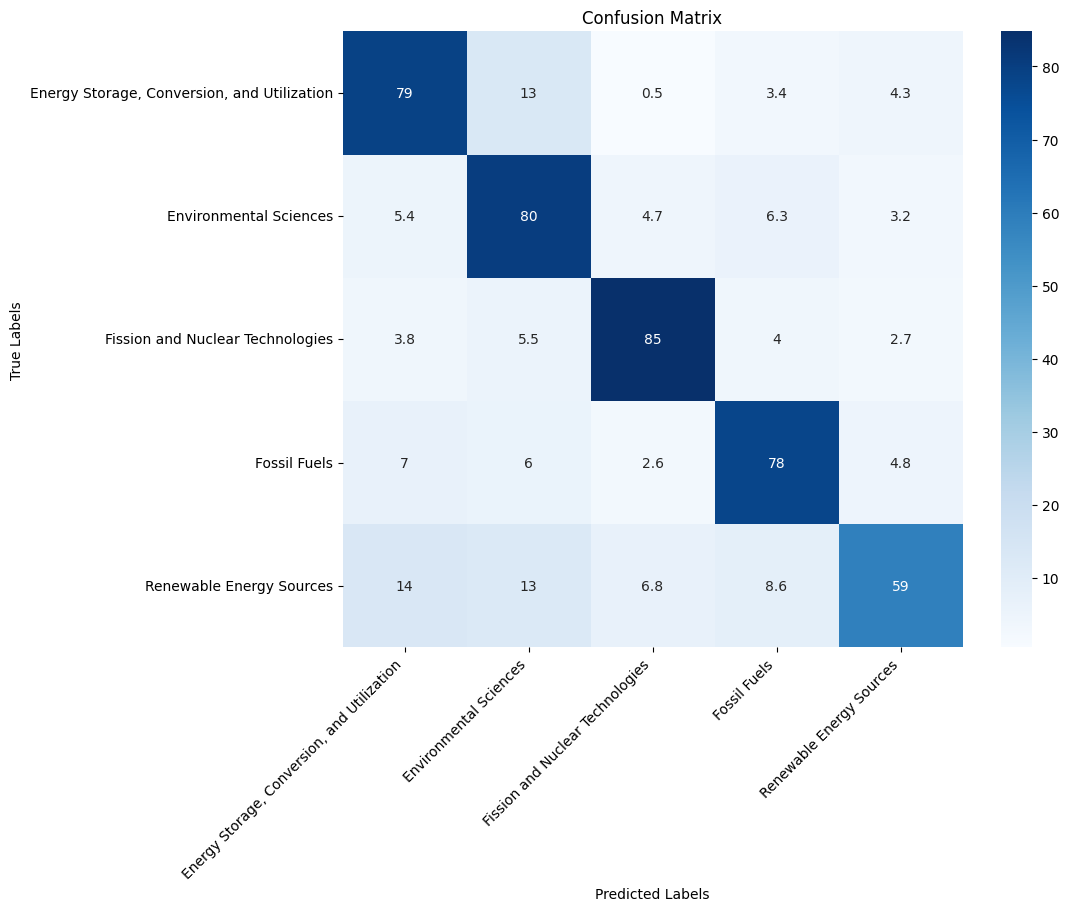

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = np.array([[78.9, 13.2,  0.5,  3.4,  4.3],
 [ 5.4, 80.2, 4.7 ,  6.3,  3.2],
 [ 3.8, 5.5 , 84.8,  4. ,  2.7],
 [ 7. , 6.  , 2.6 , 78.2,  4.8],
 [13.5, 12.6, 6.8 ,  8.6, 59.1]])


# Create a heatmap 
plt.figure(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', xticklabels=list(CATEGORY_DICT.values()), yticklabels=list(CATEGORY_DICT.values()))
plt.xticks(rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Understanding why some texts are correctly versus incorrectly classified.

In [76]:
def get_predictions(model, dataloader):
    model.eval()
    predicted_labels = []
    true_labels = []
    texts = []
    for x, y, l, t in dataloader:
        x = x.long()
        y = y.long()
        y_pred = model(x, l)
        pred = torch.max(y_pred, 1)[1]
        predicted_labels.extend(pred.tolist())
        true_labels.extend(y.tolist())
        texts.extend(t) 
    return predicted_labels, true_labels, texts

predicted_labels, true_labels, texts = get_predictions(model_variable, val_dl)


In [77]:
correctly_classified_abstracts = []
incorrectly_classified_abstracts = []
for i in range(len(true_labels)):
    if predicted_labels[i] == true_labels[i]:
        correctly_classified_abstracts.append({"text":texts[i], "label": true_labels[i]})
    else:
        incorrectly_classified_abstracts.append({"text": texts[i], "true": true_labels[i], "predicted": predicted_labels[i]})


In [79]:
import matplotlib.pyplot as plt


def analyze_length(correct_passages, incorrect_passages, category):
    correct_lengths = [len(text) for text in correct_passages]
    incorrect_lengths = [len(text) for text in incorrect_passages]

    # Plot length distribution
    plt.hist(correct_lengths, bins=20, alpha=0.5, label='Correctly Classified')
    plt.hist(incorrect_lengths, bins=20, alpha=0.5, label='Incorrectly Classified')
    plt.xlabel('Abstract Length')
    plt.ylabel('Count')
    plt.title("Distribution of Abstract Length\nCategory: {}".format(CATEGORY_DICT[category]))
    plt.legend()
    plt.show()


In [62]:
def get_abstracts_text_list(correctly_classified_abstracts, incorrectly_classified_abstracts, category):
  '''
  For a given category, returns two lists: one containing correctly classified
  passages and one containing incorrectly classified passages
  '''
  category_abstracts_correct = []
  for x in correctly_classified_abstracts:
    if x['label'] == category:
      category_abstracts_correct.append(x['text'])

  category_abstracts_incorrect = []
  for x in incorrectly_classified_abstracts:
    if x['true'] == category:
      category_abstracts_incorrect.append(x['text'])

  return category_abstracts_correct, category_abstracts_incorrect

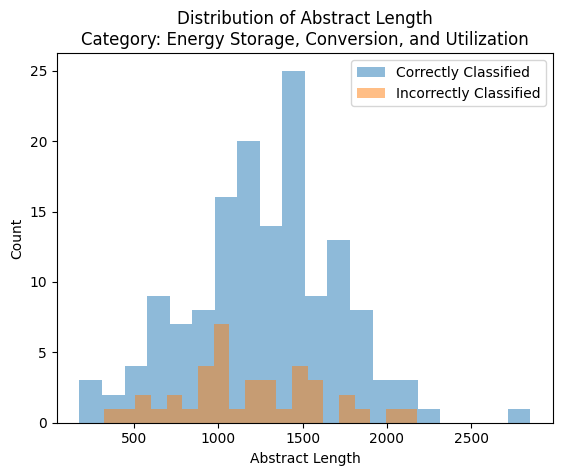

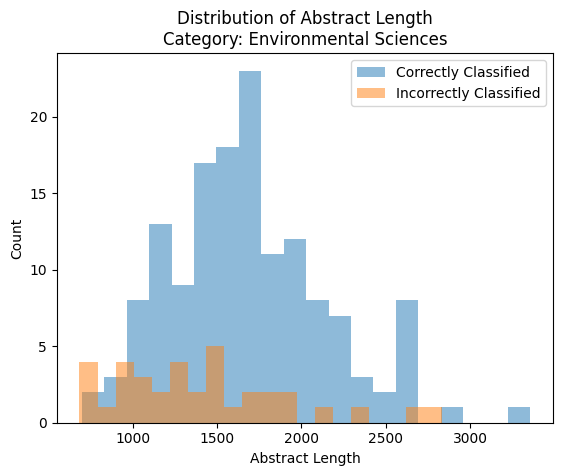

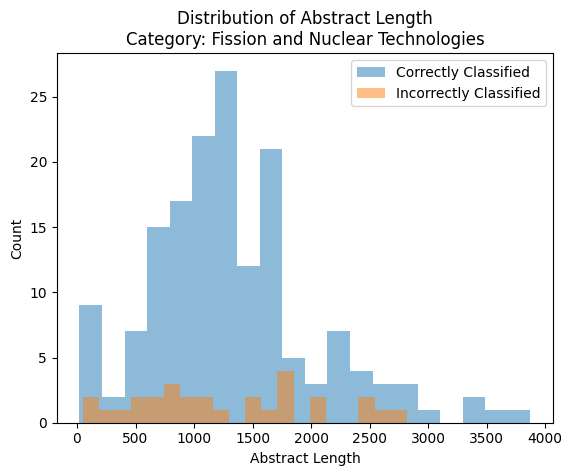

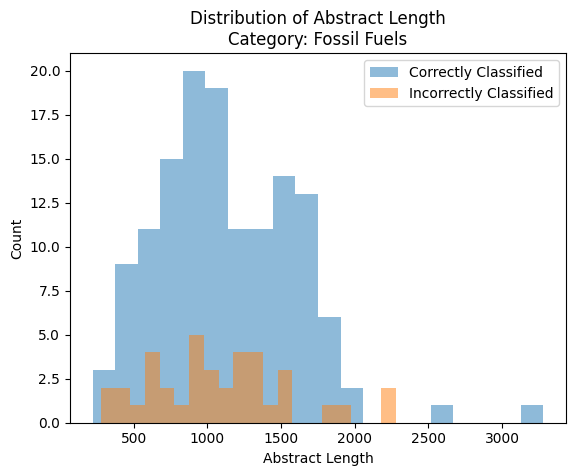

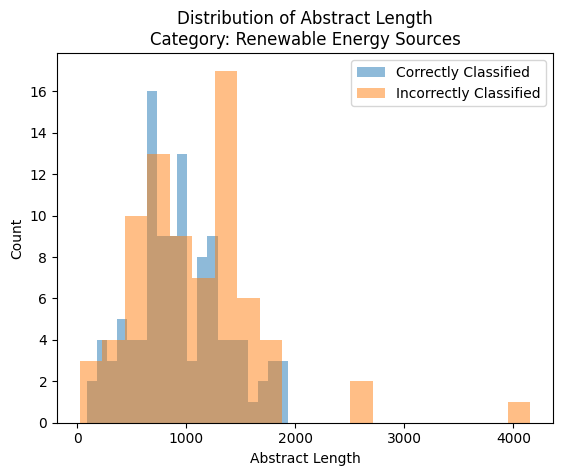

In [80]:
for category in range(5):
  abstracts_list_correct, abstracts_list_incorrect = get_abstracts_text_list(correctly_classified_abstracts, incorrectly_classified_abstracts, category)
  analyze_length(abstracts_list_correct, abstracts_list_incorrect, category)

In [81]:
from sklearn.feature_extraction.text import CountVectorizer

def analyze_ngrams(correct_passages, incorrect_passages, ngram_range):
    vectorizer = CountVectorizer(ngram_range=ngram_range)

    correct_ngrams = vectorizer.fit_transform(correct_passages)
    incorrect_ngrams = vectorizer.transform(incorrect_passages)

    # Get n-gram feature names
    feature_names = vectorizer.get_feature_names_out()

    # Get sum of n-gram occurrences across passages
    correct_ngram_counts = correct_ngrams.sum(axis=0)
    incorrect_ngram_counts = incorrect_ngrams.sum(axis=0)

    # Get top n-grams
    top_n = 10
    top_correct_ngrams = [(feature_names[idx], count) for idx, count in
                          sorted(enumerate(correct_ngram_counts.tolist()[0]), key=lambda x: -x[1])[:top_n]]
    top_incorrect_ngrams = [(feature_names[idx], count) for idx, count in
                            sorted(enumerate(incorrect_ngram_counts.tolist()[0]), key=lambda x: -x[1])[:top_n]]

    # Print top n-grams
    print('Correctly Classified Top {} {}-grams:\n'.format(top_n, ngram_range), top_correct_ngrams)
    print('Incorrectly Classified Top {} {}-grams:\n'.format(top_n, ngram_range), top_incorrect_ngrams)

# Usage
for category in range(5):
  abstracts_list_correct, abstracts_list_incorrect = get_abstracts_text_list(correctly_classified_abstracts, incorrectly_classified_abstracts, category)
  print('--', CATEGORY_DICT[category], '--')
  analyze_ngrams(abstracts_list_correct, abstracts_list_incorrect, ngram_range=(4, 4))


-- Energy Storage, Conversion, and Utilization --
Correctly Classified Top 10 (4, 4)-grams:
 [('sub sub sub sub', 58), ('sub sub mn sub', 15), ('sub co sub sub', 13), ('sub sub co sub', 12), ('sub mn sub sub', 11), ('li sub sub sub', 10), ('of li sub sub', 9), ('in this work we', 8), ('co sub sub sub', 7), ('li sub sub batteries', 7)]
Incorrectly Classified Top 10 (4, 4)-grams:
 [('sub sub sup sup', 4), ('in this study we', 3), ('of co sub sub', 3), ('sub al sub sub', 3), ('the results of the', 3), ('in the presence of', 2), ('sub sub sub sub', 2), ('sup and sub sub', 2), ('sup sup and sub', 2), ('the role of the', 2)]
-- Environmental Sciences --
Correctly Classified Top 10 (4, 4)-grams:
 [('sub sub gs sub', 9), ('sub sub sub gs', 9), ('of co sub sub', 8), ('gwi sub δα sub', 7), ('in this study we', 7), ('elevated co sub sub', 6), ('sub gs sub emissions', 6), ('sub sub sup sup', 6), ('and co sub sub', 5), ('black right pointing pointer', 5)]
Incorrectly Classified Top 10 (4, 4)-grams:

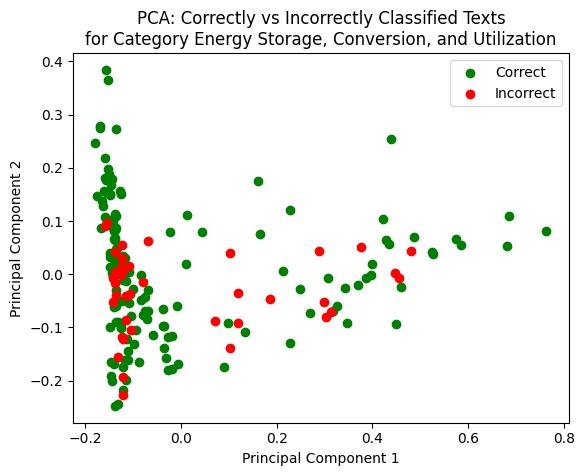

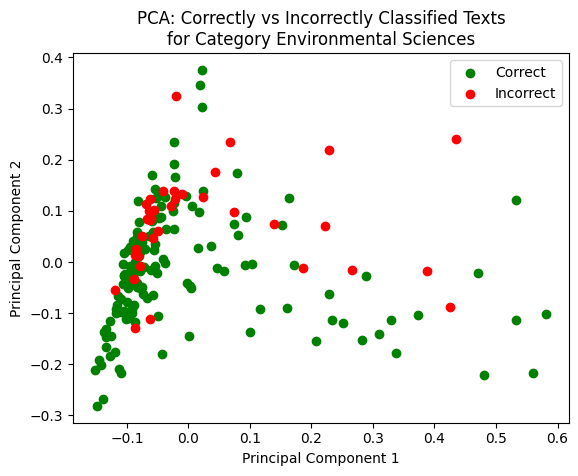

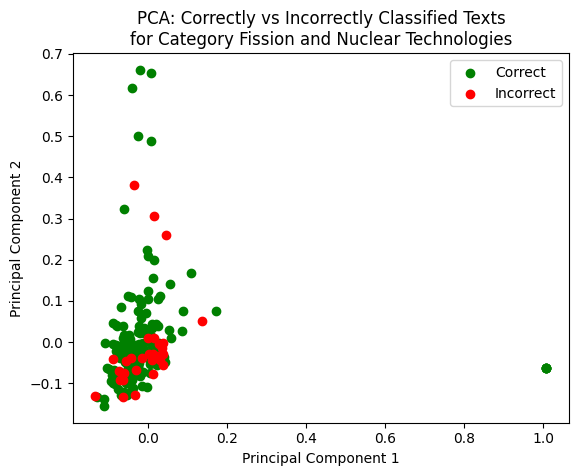

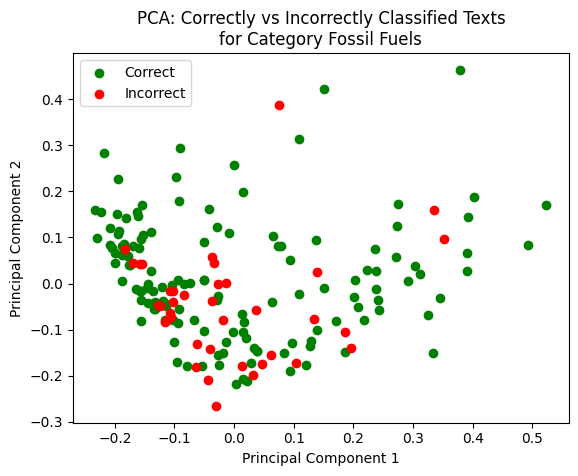

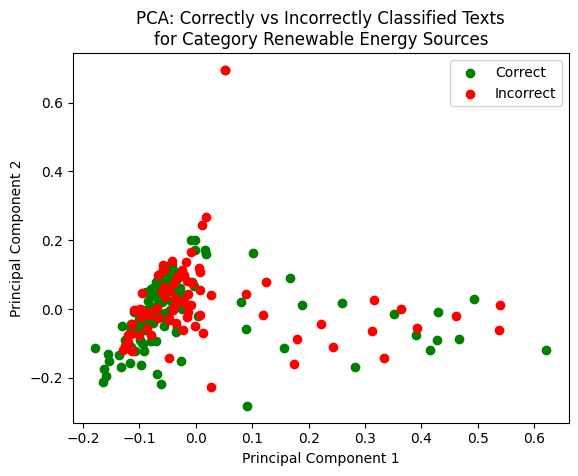

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

def perform_pca(correct_texts, incorrect_texts, category):
    # Combine the texts from both lists
    all_texts = correct_texts + incorrect_texts

    # Apply TF-IDF vectorization to convert text into numerical features
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(all_texts)

    # Perform PCA
    pca = PCA(n_components=2)
    pca_representation = pca.fit_transform(tfidf_matrix.toarray())

    # Separate the PCA representations of correct and incorrect texts
    correct_pca = pca_representation[:len(correct_texts)]
    incorrect_pca = pca_representation[len(correct_texts):]

    # Plot the PCA results
    plt.scatter(correct_pca[:, 0], correct_pca[:, 1], label='Correct', c='green')
    plt.scatter(incorrect_pca[:, 0], incorrect_pca[:, 1], label='Incorrect', c='red')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title("PCA: Correctly vs Incorrectly Classified Texts\nfor Category {}".format(CATEGORY_DICT[category]))
    plt.legend()
    plt.show()

for category in range(5):
  abstracts_list_correct, abstracts_list_incorrect = get_abstracts_text_list(correctly_classified_abstracts, incorrectly_classified_abstracts, category)
  perform_pca(abstracts_list_correct, abstracts_list_incorrect, category)


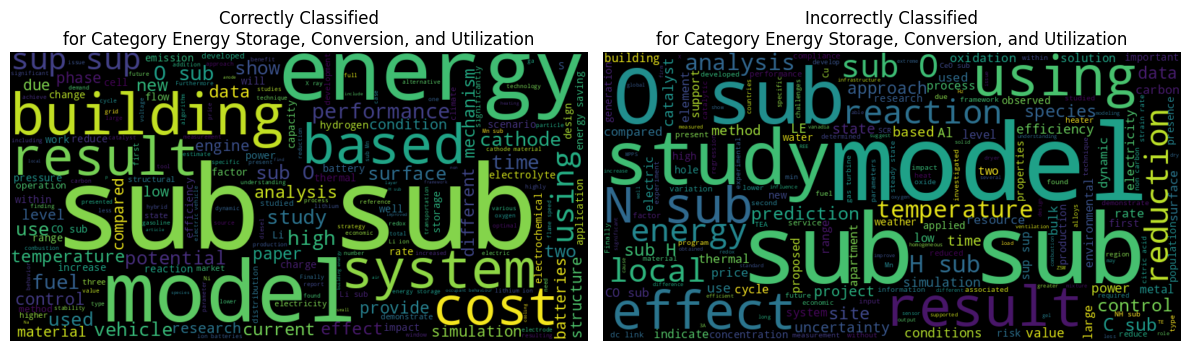

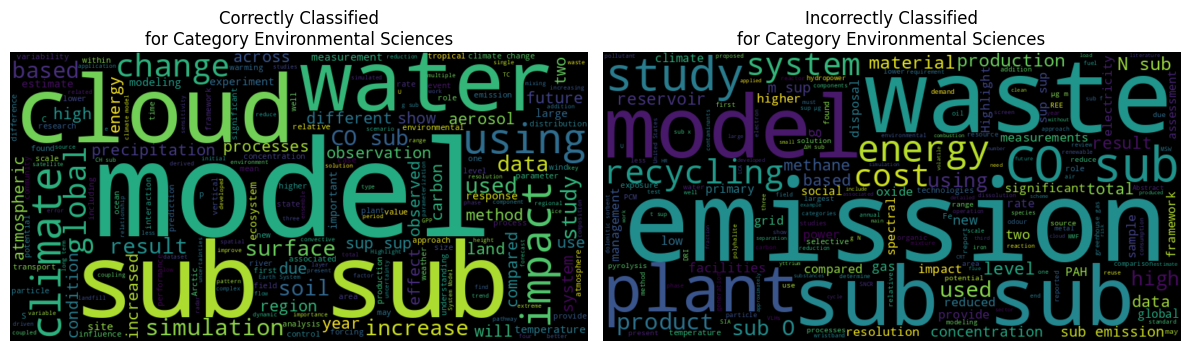

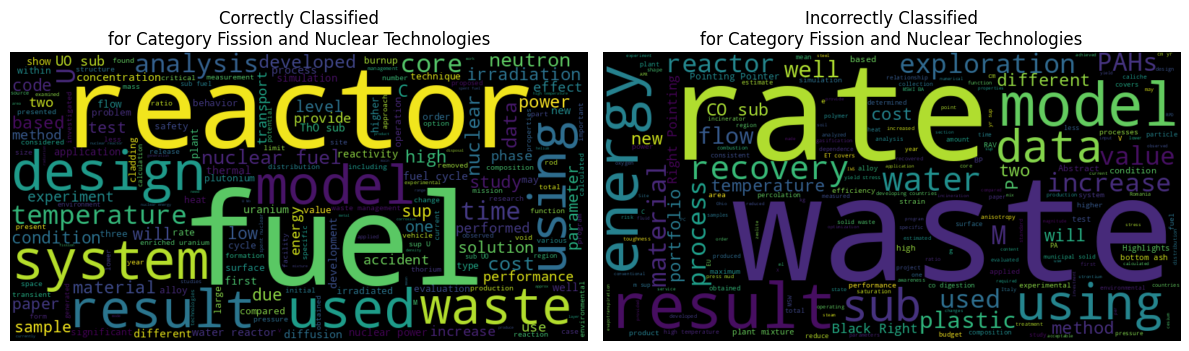

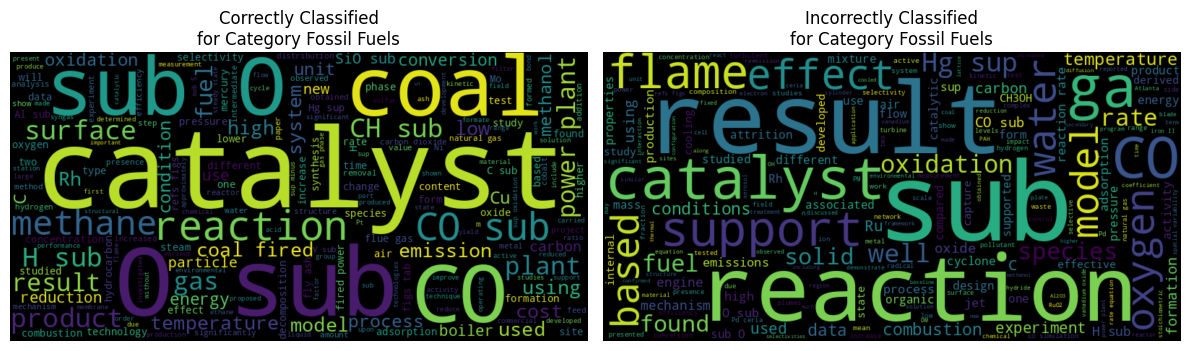

In [66]:
from wordcloud import WordCloud

def visualize_word_cloud(correct_passages, incorrect_passages, category):
    correct_words = ' '.join(correct_passages)
    incorrect_words = ' '.join(incorrect_passages)

    # Generate word clouds
    correct_wordcloud = WordCloud(width=800, height=400).generate(correct_words)
    incorrect_wordcloud = WordCloud(width=800, height=400).generate(incorrect_words)

    # Plot word clouds
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(correct_wordcloud, interpolation='bilinear')
    plt.title("Correctly Classified\nfor Category {}".format(CATEGORY_DICT[category]))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(incorrect_wordcloud, interpolation='bilinear')
    plt.title("Incorrectly Classified\nfor Category {}".format(CATEGORY_DICT[category]))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
for category in range(4):
  abstracts_list_correct, abstracts_list_incorrect = get_abstracts_text_list(correctly_classified_abstracts, incorrectly_classified_abstracts, category)
  visualize_word_cloud(abstracts_list_correct, abstracts_list_incorrect, category)


---------------

GloVe

In [ ]:
# GLOVE_FILE = os.path.join(PATH + "glove.6B.300d.txt")

# def load_glove_vectors(glove_file = GLOVE_FILE):
#     """Load the glove word vectors"""
#     word_vectors = {} 
#     with open(glove_file) as f:
#         for line in f:
#             split = line.split()
#             word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
#     return word_vectors


# def get_emb_matrix(pretrained, word_counts, emb_size):
#     """ Creates embedding matrix from word vectors"""
#     vocab_size = len(word_counts) + 2
#     vocab_to_idx = {}
#     vocab = ["", "UNK"]
#     W = np.zeros((vocab_size, emb_size), dtype="float32")
#     W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
#     W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
#     vocab_to_idx["UNK"] = 1
#     i = 2
#     for word in word_counts:
#         if word in word_vecs:
#             W[i] = word_vecs[word]
#         else:
#             W[i] = np.random.uniform(-0.25,0.25, emb_size)
#         vocab_to_idx[word] = i
#         vocab.append(word)
#         i += 1   
#     return W, np.array(vocab), vocab_to_idx

In [ ]:
# word_vecs = load_glove_vectors()
# pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts, EMBEDDING_DIM)

In [ ]:
# DROPOUT = 0.1

# class LSTM_glove_vecs(torch.nn.Module) :
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
#         super().__init__()
#         self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
#         self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
#         self.embeddings.weight.requires_grad = False ## freeze embeddings
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
#         self.linear = nn.Linear(hidden_dim, 5)
#         self.dropout = nn.Dropout(DROPOUT)
        
#     def forward(self, x, l):
#         x = self.embeddings(x)
#         x = self.dropout(x)
#         lstm_out, (ht, ct) = self.lstm(x)
#         return self.linear(ht[-1])

In [ ]:
# model_glove = LSTM_glove_vecs(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, pretrained_weights)

In [ ]:
# train_model(model_glove, epochs=NUM_EPOCHS, lr=LEARNING_RATE)